# Weather --> CNN --> LSTM --> Streamflow

# Preamble

In [1]:
#check memory available for use

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 26.3 GB  | Proc size: 153.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
#first: are you working in colab?
colab = 1

if colab:
    
    #mount drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    #define path to google drive data
    dataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'

    #download required libraries that are not already in colab
    !pip install geopandas
    
else:
    
    dataPath = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import required libraries

import pandas as pd
import numpy as np
#from netCDF4 import Dataset
%tensorflow_version 2.x
import tensorflow
import tensorflow.keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, LSTM, Flatten, TimeDistributed, Dropout, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Sequential, regularizers
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.cluster import KMeans
from scipy import interpolate
import time
import seaborn as sns

TensorFlow 2.x selected.


In [0]:
#define functions that we'll use

def nse(y_obs, y_model):

  """
  NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x1) where N is the number of observations in time
  """

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))
  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2)
  return nse

def nse_rolling(y_obs, y_model, window, stride = 1):

  """
  NSE_rolling = nse_rolling(y_obs, y_model, window, stride)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  window --> this is the length of time over which to compute NSE, which will roll accross the total time period
  stride --> default stride = 1; length of step to take when rolling (i.e. stride = 365 computes yearly NSE with no overlap)
  """

  NSE_rolling = []

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))

  startInds = range(0, len(y_model) - window, stride)
  for startInd in startInds:
    y_model_window = y_model[startInd:startInd+window] 
    y_obs_window = y_obs[startInd:startInd+window]
    NSE = nse(y_obs_window, y_model_window)
    NSE_rolling.append(NSE)

  return NSE_rolling

def plot_AB(prov='AB'):

    """
    plot borders of alberta
    
    example:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    plot_AB()
    plt.show()
    """
    
    provIndex=0
    provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)
    provPoly = provshapes['geometry'][provIndex]
    lonBorder,latBorder = provPoly.exterior.coords.xy 

    plt.plot(lonBorder,latBorder,'k')

def rmse(target,prediction):
  """ RMSE = rmse(target,prediction) """

  return(np.sqrt(((target.reshape(-1,1) - prediction.reshape(-1,1))**2).sum()/len(target.reshape(-1,1))))

def rmse_group(*args):
  rmse_group = []
  for arg in args:
    for other_arg in args:
      rmse_group.append(rmse(arg,other_arg))

  rmse_group = np.mean(rmse_group)

  return rmse_group

# Load data and preprocess

In [0]:
#load data

pickle_in = open(dataPath + 'flowDict.pickle','rb')
flowDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'tempDict_ERA5.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'precDict_ERA5.pickle','rb')
precDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'spcHDict_ERA5.pickle','rb')
spcHDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'ssrdDict_ERA5.pickle','rb')
ssrdDict = pickle.load(pickle_in)

#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
T = tempDict['T']
Tmax = tempDict['Tmax']
Tmin = tempDict['Tmin']
P = precDict['P']
H = spcHDict['H']
S = ssrdDict['S']

In [0]:
del flowDict, tempDict, precDict, spcHDict, ssrdDict

In [0]:
#set nan values to mean values of field (ie: out of province values

meanT = np.nanmean(T)
meanTmax = np.nanmean(Tmax)
meanTmin = np.nanmean(Tmin)
meanP = np.nanmean(P)
meanH = np.nanmean(H)
meanS = np.nanmean(S)

Tall = np.copy(T)
Tall[np.where(np.isnan(Tall))] = np.nanmean(T)
T = Tall

Tmaxall = np.copy(Tmax)
Tmaxall[np.where(np.isnan(Tmaxall))] = np.nanmean(Tmax)
Tmax = Tmaxall

Tminall = np.copy(Tmin)
Tminall[np.where(np.isnan(Tminall))] = np.nanmean(Tmin)
Tmin = Tminall

Pall = np.copy(P)
Pall[np.where(np.isnan(Pall))] = np.nanmean(P)
P = Pall

Hall = np.copy(H)
Hall[np.where(np.isnan(Hall))] = np.nanmean(H)
H = Hall

Sall = np.copy(S)
Sall[np.where(np.isnan(Sall))] = np.nanmean(S)
S = Sall

In [0]:
#select subset of stations?

customStations = 1

if customStations:

  stationInds = np.array([18,19,34,35,59,60,61,64,69,102,103,104,106,107,127,150,163,176]) - 1
  stationInds = np.array([1,2,3,9,13,26,27,41,49,62,68,76,77,78,86,120,130,131,132,134,167,18,19,34,35,59,60,61,64,69,102,103,104,106,107,127,150,163,176])-1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s
  stationInds = np.array([2,13,27,41,62,78,86,120,131,132,134,167,19,35,59,60,61,64,102,103,106,107,127,150,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans
  stationInds = np.array([2,13,27,62,86,120,132,134,167,19,35,59,60,64,102,103,106,107,127,150,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans, and don't have a min flow close to zero
  stationInds = np.array([19,35,59,60,64,102,103,106,107,127,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans, and don't have a min flow close to zero
  F = np.asarray(F)
  F = np.transpose(np.squeeze(F[stationInds]))

else:

  stationInds = np.arange(0,194,1)
  F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))

In [0]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))
finYear = min(int(np.max(eraYears)),int(np.max(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

indFinERA = max(np.argwhere(eraYears==finYear))[0]
indFinFlow = max(np.argwhere(flowYears==finYear))[0]

F = F[indStartFlow:indFinFlow]
T = np.asarray(T[indStartERA:indFinERA])
Tmax = np.asarray(Tmax[indStartERA:indFinERA])
Tmin = np.asarray(Tmin[indStartERA:indFinERA])
P = np.asarray(P[indStartERA:indFinERA])
H = np.asarray(H[indStartERA:indFinERA])
S = np.asarray(S[indStartERA:indFinERA])

flowDays = flowDays[indStartFlow:indFinFlow]
flowMonths = flowMonths[indStartFlow:indFinFlow]
flowYears = flowYears[indStartFlow:indFinFlow]

eraDays = eraDays[indStartERA:indFinERA]
eraMonths = eraMonths[indStartERA:indFinERA]
eraYears = eraYears[indStartERA:indFinERA]

In [0]:
#reduce spatial extent to only bound the stations of interest (reduce memory requirements)

minLon = np.min(stationLon[stationInds])
maxLon = np.max(stationLon[stationInds])
minLat = np.min(stationLat[stationInds])
maxLat = np.max(stationLat[stationInds])

indMinLonERA = np.argmin(np.abs(eraLon - minLon))
indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
indMinLatERA = np.argmin(np.abs(eraLat - minLat))
indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

T = T[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
Tmax = Tmax[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
Tmin = Tmin[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
P = P[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
H = H[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
S = S[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]

In [23]:
print(np.shape(F),np.shape(T),np.shape(P),np.shape(H),np.shape(S))

(8765, 12) (8765, 18, 24) (8765, 18, 24) (8765, 18, 24) (8765, 18, 24)


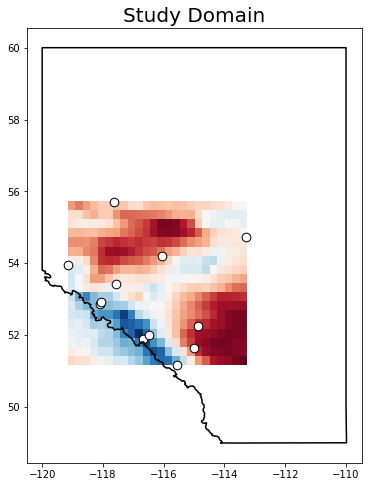

In [24]:
extentERA = [minLon,maxLon,minLat,maxLat]

plt.figure(figsize = (6,8))
plot_AB()
plt.imshow(T[0],aspect='auto',extent = extentERA, cmap = 'RdBu_r')
plt.scatter(stationLon[stationInds],stationLat[stationInds], facecolor = 'w', edgecolor = 'k', s = 75)
plt.title('Study Domain',fontsize = 20)

plt.show()

In [0]:
#prep data: standardize

#indices of testing/training
trainStartYear = 1987
trainFinYear = 2005
testStartYear = 2006
testFinYear = 2010

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))

#standardize variables individually (normalize wrt training period), then save as 32-bit rather than 64-bit for space
Tmean_train = np.mean([T[trainInds[ii]] for ii in range(len(trainInds))])
Tstd_train = np.std([T[trainInds[ii]] for ii in range(len(trainInds))])
Tnorm = (T - Tmean_train)/Tstd_train
Tnorm = np.single(Tnorm)

Tmaxmean_train = np.mean([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train = np.std([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminmean_train = np.mean([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train = np.std([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

Hmean_train = np.mean([H[trainInds[ii]] for ii in range(len(trainInds))])
Hstd_train = np.std([H[trainInds[ii]] for ii in range(len(trainInds))])
Hnorm = (H - Hmean_train)/Hstd_train
Hnorm = np.single(Hnorm)

Smean_train = np.mean([S[trainInds[ii]] for ii in range(len(trainInds))])
Sstd_train = np.std([S[trainInds[ii]] for ii in range(len(trainInds))])
Snorm = (S - Smean_train)/Sstd_train
Snorm = np.single(Snorm)

##Fmean_train = np.nanmean([F[ii][trainInds[366:]] for ii in range(len(F))])
##Fstd_train = np.nanstd([F[ii][trainInds[366:]] for ii in range(len(F))])
#Fmean_train = np.mean(F[trainInds[366:],:])
#Fstd_train = np.std(F[trainInds[366:],:])
#Fnorm = (F - Fmean_train)/Fstd_train
#Fnorm = np.single(Fnorm)

In [0]:
#normalize flow

Fnorm = np.empty_like(F)
for station in range(np.shape(F)[1]):
    #F[:,station] = (F[:,station] - np.mean(F[:,station]))/np.std(F[:,station])
    minF = np.min(F[:,station])
    maxF = 2 * np.std(F[:,station])
    Fnorm[:,station] = (F[:,station] - minF) / (maxF - minF)
    
#for inds in np.argwhere(F>10):
#  F[inds[0],inds[1]] = 10

In [0]:
#construct train and test predictor/target tensors

#target data
#y_train = np.squeeze([Fnorm[366:len(trainInds)+366,ii] for ii in range(np.shape(Fnorm)[1])])
#y_test = np.squeeze([Fnorm[testInds[1:],ii] for ii in range(np.shape(Fnorm)[1])])
#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T
y = np.empty((len(y_train[:,0])+len(y_test[:,0]),np.shape(F)[1])).T
y[:,:len(y_train[:,0])] = y_train.T
y[:,len(y_train[:,0]):] = y_test.T
y = y.T

#first, make (n_time x n_lon x n_lat x n_vars) tensor 
#x_intermediate = np.zeros((8766,17,43,2))
nchannels = 3
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype=np.float16)#'single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm
#x_intermediate[:,:,:,3] = Hnorm
#x_intermediate[:,:,:,4] = Snorm
x_train_intermediate = x_intermediate[trainInds]
x_test_intermediate = x_intermediate[testInds]

In [0]:
#now, convert x_intermediate into (n_time x 365 x n_lon x n_lat x n_vars) tensor
#x = np.zeros((8765-365,365,45,41,5),dtype='single')
x_train = np.empty((len(trainInds) - 365, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
x_test = np.empty((len(testInds), 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

In [0]:
for ii in range(1000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(1000,2000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(2000,3000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(3000,4000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(4000,len(trainInds)-365):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(1000):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [0]:
for ii in range(1000,2000):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [0]:
for ii in range(1000,len(testInds)):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [0]:
for ii in range(2000,len(testInds)-1):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [36]:
#CNN model
print('Building model...')

learning_rate = 0.0001

model = Sequential()

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

#model.add(TimeDistributed(
#    Conv2D(filters = 32, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
#    ))
#
#model.add(TimeDistributed(
#    Conv2D(filters = 32, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
#    ))

#model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(rate = 0.2))

#LSTM model with time-distributed CNN as input
#model.add(LSTM(units = 40, activation='tanh', recurrent_activation='hard_sigmoid', 
#               use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
#               bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
#               recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#               kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, implementation=1, 
#               return_sequences=True, return_state=False))
#model.add(LSTM(units = 40, activation='tanh', recurrent_activation='hard_sigmoid', 
#               use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
#               bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
#               recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#               kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, implementation=1, 
#               return_sequences=False, return_state=False))
#model.add(Dense(194, activation = 'relu'))

model.add(LSTM(40, return_sequences=True))
model.add(Dropout(rate=0.2))
#model.add(LSTM(20, return_sequences=True))
#model.add(Dropout(rate=0.1))

model.add(Flatten())
model.add(Dense(np.shape(Fnorm)[1], activation = 'linear'))

#compile
print('Compiling model...')
model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate),
              )

es = EarlyStopping(monitor='val_loss', 
                   mode = 'min',
                   verbose = 1, 
                   patience = 3,
                   restore_best_weights = True)

model.summary()

Building model...
Compiling model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 365, 18, 24, 8)    224       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 365, 18, 24, 8)    584       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 365, 9, 12, 8)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 365, 9, 12, 16)    528       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 365, 9, 12, 16)    1040      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 365, 4, 6, 16)     0         
_________________________________________________________________
time_distributed_6 

In [37]:
np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test)

((6575, 365, 18, 24, 3), (6575, 12), (1825, 365, 18, 24, 3), (1825, 12))

In [38]:
#train model

trainModel = 1

batch_size = 256
epochs = 40

if trainModel == 1:

  history = model.fit(x_train,y_train, 
                      validation_split = 0.2,
                      shuffle = True, 
                      epochs = epochs, 
                      batch_size = batch_size,
                      verbose = 1)#, 
                      #callbacks = [es])

Train on 5260 samples, validate on 1315 samples
Epoch 1/40
 256/5260 [>.............................] - ETA: 1:09

InternalError: ignored

In [0]:
#save model

saveModel = 0
glacierStations = 0

if saveModel == 1:

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs'
    model.save(modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_' + str(epochs) + '_epochs'
    model.save(modelName + '.h5')

In [0]:
#load model

loadModel = 0

if loadModel == 1:

  dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs'
    model = load_model(dataPath + modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_' + str(epochs) + '_epochs'
    model = load_model(dataPath + modelName + '.h5')

  #model = load_model(dataPath + str(num_stations) + '_stations_LSTM_DO_LSTM_DENSE.h5')

In [0]:
model_bulk = keras.models.clone_model(model)

In [0]:
#plot loss

saveIt = 0

if trainModel:

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.plot(loss, 'y', label='Training')
  plt.plot(val_loss, 'r', label='Validation')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  #plt.xlim((1,10))
  #plt.ylim((0,.1))
  #plt.show()

  if saveIt:
    plt.savefig('loss.png')

In [0]:
#predict streamflow with trained model

y_testPredict = model.predict(x_test, batch_size = 8192, verbose = 1)
y_predict = model.predict(x, batch_size=8192, verbose = 1)

In [0]:
#compute NSE

obs_per_station_test = int(len(y_test)/num_stations)
window = 366
NSE = nse(y_test,y_testPredict)
NSE_rolling = nse_rolling(y_test, y_testPredict, window, stride = 365)
NSE_station = [nse(y_test[kk*obs_per_station_test:(kk+1)*obs_per_station_test], y_testPredict[kk*obs_per_station_test:(kk+1)*obs_per_station_test]) for kk in range(num_stations)]

print('Overall NSE = ' + str(NSE)[:4])
print('Mean Station NSE = ' + str(np.mean(NSE_station))[:4])
print('Median Station NSE = ' + str(np.median(NSE_station))[:4])

In [0]:
#visualize stations' performance

sns.set(color_codes=True)
sns.distplot(NSE_station, bins = 5)
plt.show()

In [0]:
#plot model vs observed scatter plot

saveIt = 0

plt.figure(figsize = (8,8))

plt.scatter(y_test, y_testPredict, alpha = 0.1)
plt.xlabel('observation')
plt.ylabel('model')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
#plt.xlim((-2,5))
#plt.xlim((0,4))
#plt.yscale('log')
#plt.xscale('log')

if saveIt:
  plt.savefig('obs_vs_model.png')

In [0]:
#plot time series of model and observations 

saveIt = 0

plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
plt.plot(y_test, label = 'Observed')
plt.plot(y_testPredict, label = 'Modelled')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
plt.xlim((0,len(y_test)))
plt.xlim((4*365*4,4*365*5))
plt.ylim((0,3))

plt.subplot(2,1,2)
#plt.plot(range(int(window/2),len(y_test)-int(window/2)),NSE_rolling)
plt.scatter(range(len(NSE_rolling)),NSE_rolling)
plt.ylim((0,1))
plt.xlim((0,len(NSE_rolling)))
plt.xlim((15.5,19.5))
plt.xlabel('Day')
plt.ylabel('NSE')
plt.title('Rolling NSE: Window = ' + str(window) + ' Days')

plt.tight_layout()

if saveIt:
  plt.savefig('modelled_time_series.png')

plt.show()